# Praca domowa z ML numer 3

<a href="https://colab.research.google.com/github/tomczj/ML24_25/blob/main/Linear_Regression/homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

##### Odpowiedzi na poszczególne pytania pomocnicze zostały zawarte w różnych miejscach tego pliku, aby móc wesprzeć się wykresami i wyliczeniami.

# Wstęp

##### W tej pracy domowej oszacujemy dwa modele regresji logistycznej na dwóch różnych danych w celu identyfikacji różnych progów odcięcia w zależności od celu, który będziemy chcieli osiągnąć. Pierwszy zbiór danych to baza danych dotycząca raka piersi u pacjentek. Dane są podzielone na dwie grupy. Jedna grupa to pacjentki, u których wykryto nowotwór złośliwy, a druga grupa to pacjentki, u których nowotwór okazał się nie być złośliwy. 

##### Druga baza danych dotyczy filtrowania spamu i pochodzi z Kaggle. Baza składa się ze sporej ilości obserwacji, a kolumny to częstotliwość używania najpopularniejszych wyrazów. 

##### Bazy danych zostały dobrane tak, aby spojrzeć na problem wyznaczania progu decyzyjnego w regresji logistycznej z dwóch perspektyw. W przypadku danych medycznych kluczowe jest minimalizowanie fałszywie negatywnych wyników – lepiej zaklasyfikować pacjentkę jako chorą, nawet jeśli w rzeczywistości jest zdrowa (ponieważ można przeprowadzić dodatkowe testy i wykluczyć chorobę), niż uznać ją za zdrową, gdy faktycznie jest chora. Z kolei w wykrywaniu spamu priorytetem jest unikanie fałszywie pozytywnych wyników – bardziej problematyczne jest błędne oznaczenie zwykłej wiadomości jako spam (co może prowadzić do utraty ważnej korespondencji) niż przepuszczenie niechcianej wiadomości do skrzynki odbiorczej.


##### Można zatem powiedzieć, że w niektórych sytuacjach jak np. dane medyczne "lepszy" będzie model, który będzie miał wyższą wrażliwość niż swoistość. W przypadku filtrowania spamu "lepszy" będzie model o wyższej swoistości.

##### Dobór (innego niż domyślny) poziomu odcięcia w regresji logistycznej pozwala na lepsze dostosowowanie naszego klasyfikatora do zadanego zadania. Jak opisane powyżej chcielibyśmy, aby np. do daych medycznych znaleźć poziom odcięcia, który da nam wyższą wrażliowść (dla filtrowania spamu - odwrotnie - swoistość).

## Dane oraz ich obróbka

In [2]:
spam_data = pd.read_csv("emails.csv")
cancer_data = pd.read_csv("data-2.csv")

#zapewnienie powtarzalności wyników
np.random.seed(0)

In [3]:
#obróbka danych
cancer_data.drop(columns = ["id" , "Unnamed: 32"], inplace = True)
#przyjmujemy oznaczenia M (malicious) -> 1, B (benign) -> 0
cancer_data["diagnosis"] = cancer_data["diagnosis"].apply(lambda x: 1 if x == "M" else 0)
#usuwanie NaN
cancer_data = cancer_data.dropna()
cancer_data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


##### Dane do filtrowania spamu mają sporo kolumn, więc można ewentualnie zastosować PCA do znalezienia najważniejszych elementów. Zoabczymy jak długo model będzie się liczył

In [4]:
spam_data.drop(columns = ["Email No."], inplace = True)
spam_data = spam_data.dropna()
spam_data.describe()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
count,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,...,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000,5172.000000
mean,6.640565,6.188128,5.143852,3.075599,3.124710,2.627030,55.517401,2.466551,2.024362,10.600155,...,0.005027,0.012568,0.010634,0.098028,0.004254,0.006574,0.004060,0.914733,0.006961,0.290023
std,11.745009,9.534576,14.101142,6.045970,4.680522,6.229845,87.574172,4.314444,6.967878,19.281892,...,0.105788,0.199682,0.116693,0.569532,0.096252,0.138908,0.072145,2.780203,0.098086,0.453817
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,1.000000,1.000000,2.000000,1.000000,28.000000,1.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,7.000000,4.000000,3.000000,4.000000,2.000000,62.250000,3.000000,1.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,210.000000,132.000000,344.000000,89.000000,47.000000,77.000000,1898.000000,70.000000,167.000000,223.000000,...,4.000000,7.000000,2.000000,12.000000,3.000000,4.000000,3.000000,114.000000,4.000000,1.000000


#### Podzielimy teraz na dane testowe, walidacyjne oraz treningowe

In [5]:
y_spam = spam_data["Prediction"]
X_spam = spam_data.iloc[:, :-1]
#podział 60% tranowanie, 20% walidacja, 20% test
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(X_spam, y_spam, test_size = 0.2)
X_spam_train, X_spam_val, y_spam_train, y_spam_val = train_test_split(X_spam_train, y_spam_train, test_size = 0.25)

In [6]:
y_cancer = cancer_data["diagnosis"]
X_cancer = cancer_data.iloc[:, 1:]
#podział 60% tranowanie, 20% walidacja, 20% test
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, test_size = 0.2)
X_cancer_train, X_cancer_val, y_cancer_train, y_cancer_val = train_test_split(X_cancer_train, y_cancer_train, test_size = 0.25)


#### Trenowanie modelu

In [7]:
#problemy ze zbieżnością, więć zwiększono max iter w obu modelach
spam_model = LogisticRegression(solver = "lbfgs" ,max_iter = 10000)
spam_model.fit(X_spam_train, y_spam_train)

LogisticRegression(max_iter=10000)

In [8]:
cancer_model = LogisticRegression(solver = "lbfgs" ,max_iter = 10000)
cancer_model.fit(X_cancer_train, y_cancer_train)

LogisticRegression(max_iter=10000)

## Krzywe ROC i wartości AUC

##### Bardzo często w przypadku próby identyfikacji odpowiednich progów odcięcia w regresji logistycznej stosuje się tzw. krzywą ROC. Krzywa ROC to wizualna reprezentacja wydajności modelu na wszystkich wartościach progowych. Idea stojąca za krzywą ROC polega na pokazaniu na wykresie jak wygląda współczynnik prawdziwe pozytywnych (True positives - TPR) względem współczynnika wyników fałszywie pozytywnych (False Positives FPR) przy różnych progach odcięcia. 

##### Innymi słowy, na krzywej ROC mamy zwizualizowane wartości (Sensitivity, 1 - Specifity) przy różnych wartościach progu odcięcia. Wobec tego krzywa ROC może pomóc w idnetyfikacji poziomu odpowiedniego do naszego celu.

##### Poniżej wykres przykładowej krzywej ROC.

(https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=pl). 

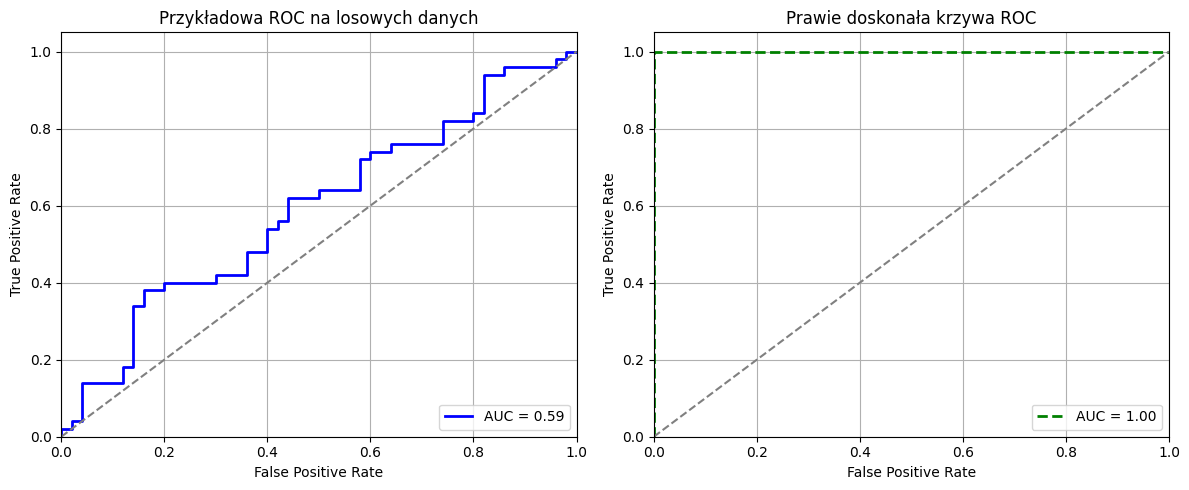

In [9]:
y_true_random = np.random.randint(0, 2, 100)
y_scores_random = np.random.rand(100)
fpr_random, tpr_random, _ = roc_curve(y_true_random, y_scores_random)
auc_random = auc(fpr_random, tpr_random)

y_true_better = np.concatenate([np.ones(50), np.zeros(50)]) 
y_scores_better = np.concatenate([np.linspace(0.7, 1.0, 50), np.linspace(0.0, 0.3, 50)])
fpr_better, tpr_better, _ = roc_curve(y_true_better, y_scores_better)
auc_better = auc(fpr_better, tpr_better)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(fpr_random, tpr_random, color='blue', lw=2, label=f'AUC = {auc_random:.2f}')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Przykładowa ROC na losowych danych')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_better, tpr_better, color='green', lw=2, linestyle='--', label=f'AUC = {auc_better:.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Prawie doskonała krzywa ROC')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()


##### Im wykres jest bliższy kwadratowi jednostkowemu tym lepszy model, bo oznacza to, że nasz model poprawie klasyfikuje poszczególne obserwacje. Wykres linii 45 stopni wskazuje na losowe przyporządkowanie, a wykres poniżej tej linii pokazuje, że nasz klasyfikator działa gorzej niż losowe przypisanie poszczególnej klasy. Tutaj pojawia się też możliwość wyznaczenia punktów odcięcia. Jednym ze stosowanych podejść jest identyfikacja progu, dla którego punkty na krzywej ROC są najblżej punktu (1,0). Intuicja stojąca za tym polega na znalezieniu progu odcięcia, przy którym klasyfikator jest najblżej perfekcyjengo klasyfikatora. Innym podejściem jest zastosowanie statystyki J Youdena zdefinowanej jako róznica między TPR i FPR. Wówczas znaleznienie odpowiedniego (odpwoiednich) progów odcięcia polega na maksymalizaji tej statyski względem poziomu odcięcia.

### Interpretacja AUC

##### Z krzywą ROC powiązana jest wartość AUC, czyli pole pod jej wykresem. AUC przyjmuje wartości od 0 do 1 i określa zdolność modelu do rozróżniania klas. AUC można interpretować jako prawdopodobieństwo, że dla dwóch losowo wybranych obserwacji – jednej pozytywnej i jednej negatywnej – model przypisze wyższe prawdopodobieństwo obserwacji pozytywnej niż negatywnej. Na przykładzie klasyfikacji spamu, AUC bliskie 1 oznacza, że klasyfikator prawie zawsze przypisuje wiadomości będącej spamem wyższe prawdopodobieństwo bycia spamem niż wiadomości, która spamem nie jest.

## Krzywe ROC i wartości AUC dla danych (do walidacji) z zadania

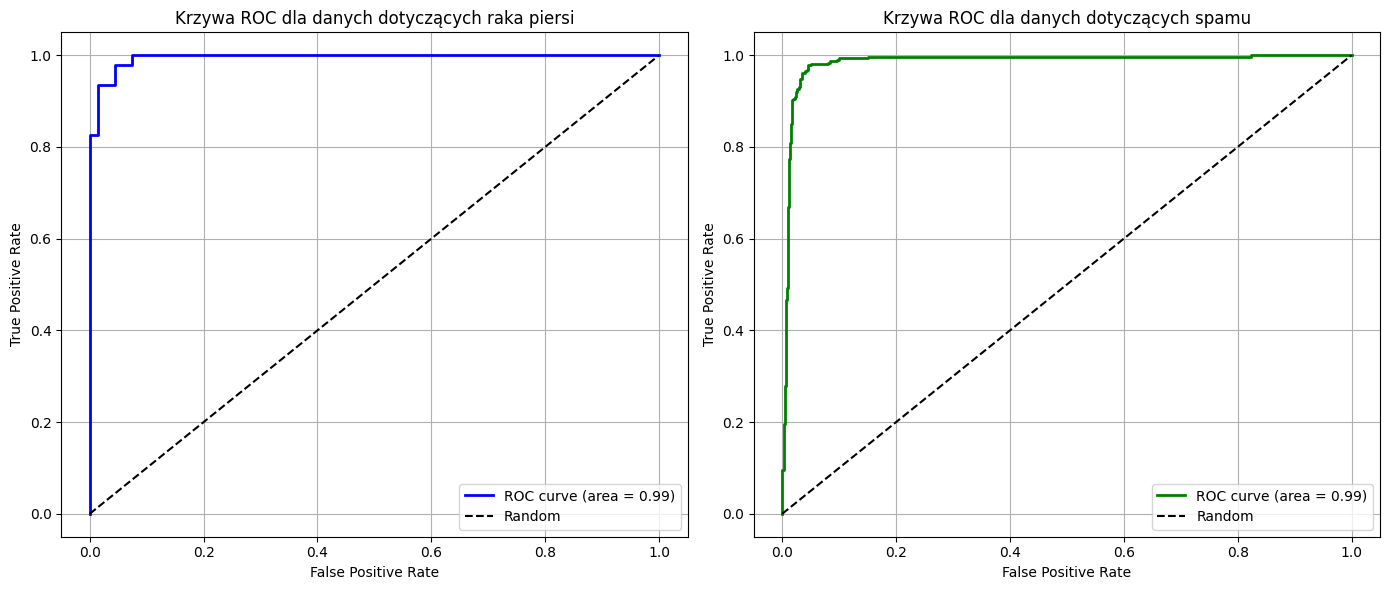

In [10]:
y_cancer_pred = cancer_model.predict_proba(X_cancer_val)[:, 1]
fpr_cancer, tpr_cancer, thresholds_cancer = metrics.roc_curve(y_cancer_val, y_cancer_pred)
roc_auc_cancer = metrics.auc(fpr_cancer, tpr_cancer)

y_spam_pred = spam_model.predict_proba(X_spam_val)[:, 1]
fpr_spam, tpr_spam, thresholds_spam = metrics.roc_curve(y_spam_val, y_spam_pred)
roc_auc_spam = metrics.auc(fpr_spam, tpr_spam)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(fpr_cancer, tpr_cancer, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_cancer:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Krzywa ROC dla danych dotyczących raka piersi')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_spam, tpr_spam, color='green', lw=2, label=f'ROC curve (area = {roc_auc_spam:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Krzywa ROC dla danych dotyczących spamu')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()

#### Zastosujemy podejście związane z maskymalizacją statysyki J Youdena. Wobec tego szukamy progu, który maksymalizuje szukaną wartość.

In [11]:
J_score_cancer = tpr_cancer - fpr_cancer
id_J_c = np.argmax(J_score_cancer)
best_th_cancer = thresholds_cancer[id_J_c]
print(best_th_cancer)


J_score_spam = tpr_spam - fpr_spam
id_J_s = np.argmax(J_score_spam)
best_th_spam = thresholds_spam[id_J_s]
print(best_th_spam)

0.053261854983821
0.3424454437540596


#### Tutaj podejście bazujące na szukaniu punktu najbliżej (0,1)

In [12]:
cancer_dist = (1-tpr_cancer)**2 + fpr_cancer**2
id_c_d = np.argmin(cancer_dist)
best_th_cancer_d = thresholds_cancer[id_c_d]
print(best_th_cancer_d)

spam_dist = (1-tpr_spam)**2 + fpr_spam**2
id_s_d = np.argmin(spam_dist)
best_th_spam_d = thresholds_spam[id_s_d]
print(best_th_spam_d)

0.053261854983821
0.3424454437540596


##### Jak widać progi się pokrywają przy obu podejściach (niekoniecznie tak musi być za każdym razem)

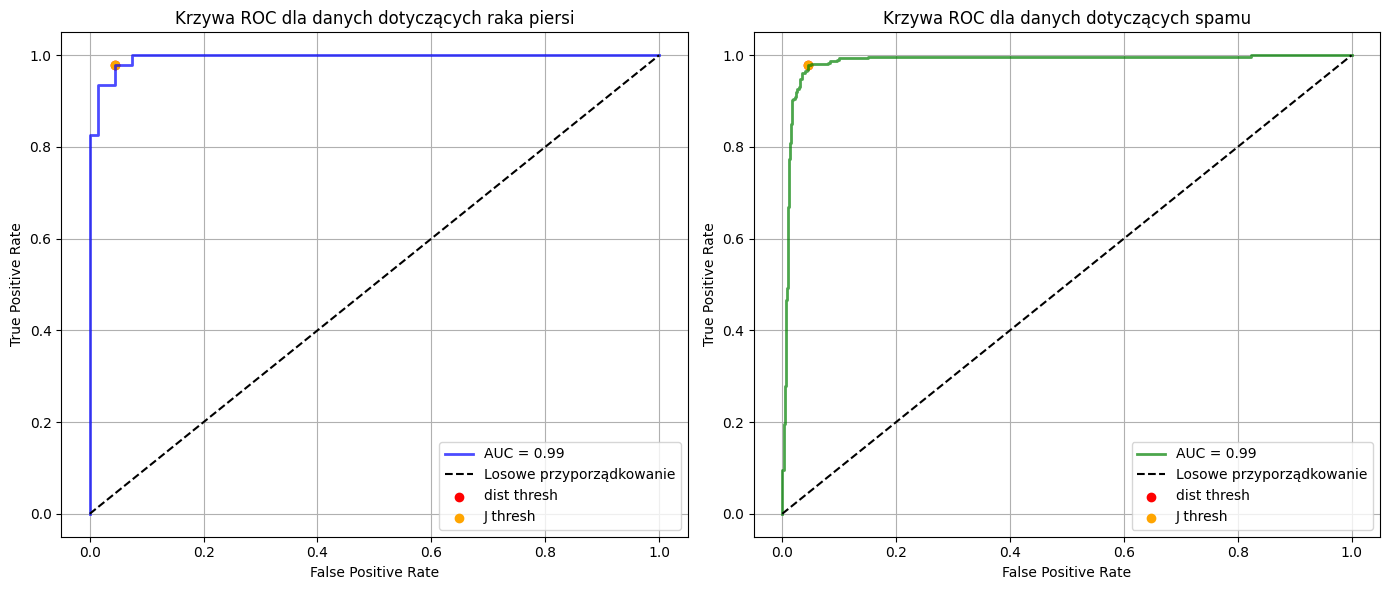

In [13]:
y_cancer_pred = cancer_model.predict_proba(X_cancer_val)[:, 1]
fpr_cancer, tpr_cancer, thresholds_cancer = metrics.roc_curve(y_cancer_val, y_cancer_pred)
roc_auc_cancer = metrics.auc(fpr_cancer, tpr_cancer)

y_spam_pred = spam_model.predict_proba(X_spam_val)[:, 1]
fpr_spam, tpr_spam, thresholds_spam = metrics.roc_curve(y_spam_val, y_spam_pred)
roc_auc_spam = metrics.auc(fpr_spam, tpr_spam)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(fpr_cancer, tpr_cancer, color='blue', lw=2, label=f'AUC = {roc_auc_cancer:.2f}', alpha = 0.7)
axes[0].plot([0, 1], [0, 1], 'k--', label='Losowe przyporządkowanie')
axes[0].scatter(fpr_cancer[id_c_d], tpr_cancer[id_c_d], color = "red", label = "dist thresh")
axes[0].scatter(fpr_cancer[id_J_c], tpr_cancer[id_J_c], color = "orange", label = "J thresh")
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Krzywa ROC dla danych dotyczących raka piersi')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].plot(fpr_spam, tpr_spam, color='green', lw=2, label=f'AUC = {roc_auc_spam:.2f}', alpha = 0.7)
axes[1].plot([0, 1], [0, 1], 'k--', label='Losowe przyporządkowanie')
axes[1].scatter(fpr_spam[id_s_d], tpr_spam[id_s_d], color = "red", label = "dist thresh")
axes[1].scatter(fpr_spam[id_J_s], tpr_spam[id_J_s], color = "orange", label = "J thresh")
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Krzywa ROC dla danych dotyczących spamu')
axes[1].legend(loc='lower right')
axes[1].grid()

plt.tight_layout()
plt.show()

##### Jeżeli byłoby wiele poziomów, które rozwiązywałyby wcześniejsze zagadanienia to dobieralibyśmy poziom odcięcia w taki sposób, aby jak najlepiej aplikował się on do naszego zagadanienia (opisane na początku). Na powyższym wykresie  zaznaczono progi odcięcia.

## Oszacowanie na danych testowowych przy zadanym (obliczonym wyżej) poziomie odcięcia

In [14]:
prob_cancer = cancer_model.predict_proba(X_cancer_test)
prob_spam = spam_model.predict_proba(X_spam_test)

def classify(x, th):
    return [1 if el > th else 0 for el in x[:, 1]]

In [15]:
class_cancer = classify(prob_cancer, best_th_cancer)
class_spam = classify(prob_spam, best_th_spam)

## Sprawdzenie zachowania modelu

### Będziemy używali kilku metryk (tłumaczenie na nasze przypadki):

#### 1. Accuracy, czyli jaki procent obserwacji model dobrze sklasyfikował.
#### 2. Precision, czyli w naszym przypadku jaki % kobiet, które według modelu mają nowotwór złośliwy rzeczywiście go miały.
#### 3. Recall, czyli jak dobrze nasz model wykrywa (w naszym przypadku), że rak piersi jest złośliwy lub, że email jest spamem.
#### 4. Specificity, czyli procent kobiet, które nie miały nowotworu złośliwego, a model poprawnie je sklasyfikował jako takie. Dla modelu do wykrywania spamu oznacza to, jaki procent maili, które nie były spamem, zostały prawidłowo sklasyfikowane jako nie-spam.
#### 5. Sensitivity - wskaźnik, jaki procent chorych kobiet na nowotwór złośliwy został prawidłowo sklasyfikowany przez model jako chore. Dla modelu do wykrywania spamu oznacza to, jaki procent maili, które były spamem, zostały prawidłowo sklasyfikowane jako spam.
#### 6. F1 score


### Dla danych dotyczących raka piersi

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

x = [cancer_model.predict(X_cancer_test), class_cancer]

model = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
indeks = ["accuracy", "precision", "recall", "F1", "sensitivity", "specificity"]

accuracy_vals = [accuracy_score(y_cancer_test, x[i]) for i in [0, 1]]
precision_vals = [precision_score(y_cancer_test, x[i]) for i in [0, 1]]
recall_vals = [recall_score(y_cancer_test, x[i]) for i in [0, 1]]
F1_vals = [f1_score(y_cancer_test, x[i]) for i in [0, 1]]

sens_vals = recall_vals  

spec_vals = []
for i in [0, 1]:
    tn, fp, fn, tp = confusion_matrix(y_cancer_test, x[i]).ravel()
    specificity = tn / (tn + fp)
    spec_vals.append(specificity)

model_data = pd.DataFrame([accuracy_vals, precision_vals, recall_vals, F1_vals, sens_vals, spec_vals])
model_data.columns = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
model_data["indeks"] = indeks
model_data.set_index("indeks", inplace=True)

model_data

,Domyślny poziom odcięcia,Poziom odcięca odczytany z ROC
indeks,,
accuracy,0.929825,0.859649
precision,0.950000,0.741379
recall,0.863636,0.977273
F1,0.904762,0.843137
sensitivity,0.863636,0.977273
specificity,0.971429,0.785714


##### W przypadku modelu mającego określić, czy dana kobieta jest chora na nowotwór złośliwy, najbardziej interesującą metryką jest czułość (sensitivity). W ogólnym przypadku lepiej, aby model sklasyfikował osobę zdrową jako chorą (ponieważ można przeprowadzić dodatkowe testy i wykluczyć chorobę), niż odwrotnie. Analizując pozostałe metryki, można zauważyć, że na pierwszy rzut oka model z domyślnym poziomem odcięcia lepiej radzi sobie w klasyfikacji. Należy jednak uwzględnić zastosowanie modelu, czyli identyfikację choroby. W związku z tym, w naszym przypadku lepszy będzie model z poziomem odcięcia wyznaczonym przy pomocy krzywej ROC.

#### Dla danych dotyczących spamu

In [17]:
x = [spam_model.predict(X_spam_test), class_spam]

model = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
indeks = ["accuracy", "precision", "recall", "F1", "sensitivity", "specificity"]

accuracy_vals = [accuracy_score(y_spam_test, x[i]) for i in [0, 1]]
precision_vals = [precision_score(y_spam_test, x[i]) for i in [0, 1]]
recall_vals = [recall_score(y_spam_test, x[i]) for i in [0, 1]]
F1_vals = [f1_score(y_spam_test, x[i]) for i in [0, 1]]

sens_vals = recall_vals

spec_vals = []
for i in [0, 1]:
    tn, fp, fn, tp = confusion_matrix(y_spam_test, x[i]).ravel()
    specificity = tn / (tn + fp)
    spec_vals.append(specificity)

model_data = pd.DataFrame([accuracy_vals, precision_vals, recall_vals, F1_vals, sens_vals, spec_vals])
model_data.columns = ["Domyślny poziom odcięcia", "Poziom odcięca odczytany z ROC"]
model_data["indeks"] = indeks
model_data.set_index("indeks", inplace=True)

model_data

,Domyślny poziom odcięcia,Poziom odcięca odczytany z ROC
indeks,,
accuracy,0.957488,0.956522
precision,0.897690,0.884615
recall,0.954386,0.968421
F1,0.925170,0.924623
sensitivity,0.954386,0.968421
specificity,0.958667,0.952000


##### W przypadku modelu mającego wykrywać spam zazwyczaj wolimy uniknąć sklasyfikowania ważnej wiadomości jako spamu, dlatego kluczową metryką jest specyficzność (specificity). Widzimy jednak, że oba modele mają zbliżone wartości w tym zakresie. Warto zaznaczyć, że model z poziomem odcięcia wyznaczonym przy pomocy krzywej ROC radzi sobie podobnie jak model z domyślnym poziomem odcięcia. Oznacza to, że standardowy poziom odcięcia nie musi być zły.